# 2. Data Cleaning


In [40]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

sns.set(style="whitegrid")
sns.set_context("poster", font_scale=.5, rc={"grid.linewidth": 0.6})
sns.set_style({'font.family': 'Roboto'})
# jupyter-book clean ./ --all
# jupyter-book build ./
# ghp-import -n -p -f _build/html

import warnings
warnings.filterwarnings("ignore")
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


### 2.1 Members Data


In [41]:
member_holdtime_df=pd.read_csv('data/member_holdtime_df.csv')
member_holdtime_df.isnull().sum()

memberID      0
holdtime      0
puzzlepack    0
dtype: int64

In [42]:
# removing outliers
member_holdtime_df = member_holdtime_df[(member_holdtime_df['holdtime'] >= 0.1) & 
                                        (member_holdtime_df['holdtime'] <= 150)]

### 2.2 Packs Data


In [43]:
packs_df=pd.read_csv('data/packs_df.csv')
packs_df.head()

,pack_name,brand,piece_count,difficulty_rating,piece_count_1,piece_count_2,difficulty_rating_1,difficulty_rating_2
0,Anne Belle Thompson The Mikado Anne Belle Thom...,Other-Hand-cut,"387,242","A-Easy,A-Easy",387.0,242.0,A-Easy,A-Easy
1,Anthology Puzzles Alphonse Mucha La Plume Anth...,NaN,"320,160","Average,Average",320.0,160.0,Average,Average
2,Anthology Puzzles Colorful Cat Anthology Puzzl...,NaN,"150,170","Really-Hard,A-Easy",150.0,170.0,Really-Hard,A-Easy
3,Anthology Puzzles Framed American Gothic Antho...,NaN,"320,300","Average,Average",320.0,300.0,Average,Average
4,Anthology Puzzles Over The Moon Anthology Puzz...,NaN,"278,177","Average,A-Easy",278.0,177.0,Average,A-Easy


In [44]:
# splitting brand name
packs_df['brand_2'] = packs_df['brand'].str.split(',', expand=True)[1]
packs_df['brand_1'] = packs_df['brand'].str.split(',', expand=True)[0]

In [45]:
# adding number of puzzles feature
packs_df['num_puzzles'] = packs_df['pack_name'].map(lambda n: 1 if (n[-1] == ' ') else 2, na_action='ignore')

In [46]:
# fixing datatype
packs_df = packs_df.astype({'piece_count_1': 'int64', 'piece_count_2': 'int64'}, errors='ignore')

In [47]:
# dropping the initial variables
packs_df.drop(['brand', 'piece_count', 'difficulty_rating'], axis=1, inplace=True)

In [48]:
packs_df.isnull().sum()

pack_name                0
piece_count_1            8
piece_count_2          181
difficulty_rating_1      4
difficulty_rating_2      4
brand_2                775
brand_1                 25
num_puzzles              0
dtype: int64

In [49]:
# making the brand_2 same as brand_1
# ------ must be done only for puzzle = 2, right?
packs_df.loc[(packs_df['brand_2'].isna()), 'brand_2'] = packs_df['brand_1']

In [50]:
packs_df[['brand_1', 'brand_2']] = packs_df[['brand_1', 'brand_2']].fillna('unknown')

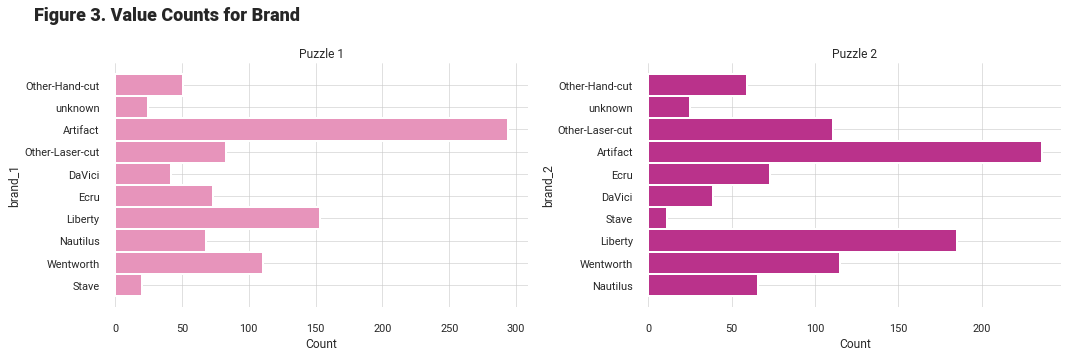

In [51]:
# Bar charts for distribution of brand
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Figure 3. Value Counts for Brand", weight='heavy',y =0.99, x=0.16).set_fontsize('18')

sns.histplot(data=packs_df, y=packs_df[packs_df['brand_1'].notnull()]['brand_1'], color="#e794bb", alpha = 1.0, ax=axs[0])
axs[0].set_title("Puzzle 1")
sns.histplot(data=packs_df, y=packs_df[packs_df['brand_2'].notnull()]['brand_2'], color="#ba328b", alpha = 1.0, ax=axs[1])
axs[1].set_title("Puzzle 2")

sns.despine(left=True, bottom=True)
fig.tight_layout()
# plt.savefig("_static/images/brand_dist.png", format="png", dpi=1200)
plt.show()

In [52]:
# Some 1 puzzle packs have a second number for pieces, this seems to be legit, updating to be 2 puzzle packs
packs_df.loc[((packs_df.num_puzzles == 1) & (packs_df.piece_count_2.notna())), 'num_puzzles'] = 2

In [53]:
packs_df.piece_count_1 = packs_df.piece_count_1.astype('float').astype('Int64')
packs_df.piece_count_2 = packs_df.piece_count_2.astype('float').astype('Int64')

avg_pc1 = packs_df['piece_count_1'].median()
avg_pc2 = packs_df['piece_count_2'].median()

In [54]:
# puzzles which have no value for piece_1 is replaced with avg values
packs_df['piece_count_1'].fillna(avg_pc1, inplace=True)

In [55]:
# if 2 puzzles and second piececount is not available, replace with average
packs_df.loc[((packs_df['piece_count_2'].isna() ) &(packs_df['num_puzzles'] ==2)), 'piece_count_2'] = int(avg_pc2)

In [56]:
# puzzles with no second piece_count, make second piece count 0 
# (because num_puzzle = 2 was dealt with earlier)
packs_df.loc[(packs_df['piece_count_2'].isna()) & (packs_df['num_puzzles'] ==1), 'piece_count_2'] = int(0)

In [57]:
packs_df.isnull().sum()

pack_name              0
piece_count_1          0
piece_count_2          0
difficulty_rating_1    4
difficulty_rating_2    4
brand_2                0
brand_1                0
num_puzzles            0
dtype: int64

In [58]:
packs_df['difficulty_rating_1'].fillna('Average', inplace=True)
packs_df['difficulty_rating_2'].fillna('Average', inplace=True)

### 2.3 Merged data

In [59]:
df = member_holdtime_df.merge(packs_df, left_on='puzzlepack', right_on='pack_name', how='left')
df.head(2)

,memberID,holdtime,puzzlepack,pack_name,piece_count_1,piece_count_2,difficulty_rating_1,difficulty_rating_2,brand_2,brand_1,num_puzzles
0,member1,2.939411,Artifact Puzzles Justin Hillgrove Word Travels...,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,A-Easy,Average,Artifact,Artifact,2.0
1,member1,0.998885,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,195,220,A-Easy,Hard,DaVici,DaVici,2.0


In [60]:
df.shape, member_holdtime_df.shape

((19387, 11), (19387, 3))

In [61]:
member_holdtime_df.puzzlepack.nunique(), packs_df.pack_name.nunique(), 

(968, 920)

In [62]:
df.isnull().sum()
# about 5% of the data is missing

memberID                  0
holdtime                  0
puzzlepack                0
pack_name              1085
piece_count_1          1085
piece_count_2          1085
difficulty_rating_1    1085
difficulty_rating_2    1085
brand_2                1085
brand_1                1085
num_puzzles            1085
dtype: int64

<div class="alert alert-block alert-info">
<b>Tip:</b> # Ideally we should have information about all the packs. Since we do not have this information and it is recommended that we do not drop these rows, we will impute these with the average values.
</div>

### 2.4 Dealing with Nulls!
**Methodology**

* num_puzzles $\longrightarrow$ Count number of times 'Puzzle' appears in puzzlepack
* brand_1, brand_2 $\longrightarrow$ Take word before 'Puzzle' as brand name
* difficulty_rating $\longrightarrow$ Take average at brand level from known data
* piece_count $\longrightarrow$ Take average at brand level from known data

In [63]:
missing_pack_data = df.loc[df['pack_name'].isna()][['puzzlepack', 'piece_count_1', 'piece_count_2',
                               'difficulty_rating_1', 'difficulty_rating_2', 'brand_1', 
                                'brand_2', 'num_puzzles']]
missing_pack_data.reset_index(drop=True, inplace=True)

In [64]:
# getting number of puzzles
missing_pack_data['num_puzzles'] = missing_pack_data['puzzlepack'].apply(lambda x: (x.count('Puzzles')))

In [70]:
# packs can have only 1 or two puzzles
for i in range(len(missing_pack_data)):
    if missing_pack_data['num_puzzles'][i] < 1:
        missing_pack_data['num_puzzles'][i] = 1
    elif missing_pack_data['num_puzzles'][i] > 2:
        missing_pack_data['num_puzzles'][i] = 2

C:\conda_tmp\ipykernel_21028\3884542231.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_pack_data['num_puzzles'][i] = 1
C:\conda_tmp\ipykernel_21028\3884542231.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_pack_data['num_puzzles'][i] = 2


In [71]:
## to limit the number of brand names we will only use the brands that we know
known_brands = list(set(packs_df['brand_1'].unique()).union(set(packs_df['brand_2'].unique())))

In [72]:
# getting brand_1
for i in range(len(missing_pack_data)):
    words = missing_pack_data['puzzlepack'][i].split()[:2]

    if 'Puzzles' in words[1:]:  # if its the second or third word
        if words[words.index('Puzzles')-1] in (known_brands):
            missing_pack_data['brand_1'][i] = words[words.index('Puzzles')-1]
        else:
            missing_pack_data['brand_1'][i] = 'unknown'


C:\conda_tmp\ipykernel_21028\3406144899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_pack_data['brand_1'][i] = words[words.index('Puzzles')-1]
C:\conda_tmp\ipykernel_21028\3406144899.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_pack_data['brand_1'][i] = 'unknown'


In [ ]:
# getting brand_2
for i in range(len(missing_pack_data)):
    words = missing_pack_data['puzzlepack'][i].split()[2:]
    if 'Puzzles' in words[1:]:  # if its the 4th word onwards
        if words[words.index('Puzzles')-1] in (known_brands):
            missing_pack_data['brand_2'][i] = words[words.index('Puzzles')-1]
        else:
            missing_pack_data['brand_2'][i] = 'unknown'


In [74]:
missing_pack_data[['num_puzzles', 'brand_1', 'brand_2']].isnull().sum()

num_puzzles      0
brand_1        139
brand_2        333
dtype: int64

In [33]:
# if anything still missing in num_puzzles, brands
missing_pack_data['num_puzzles'].fillna(1, inplace=True)
missing_pack_data['brand_1'].fillna('unknown', inplace=True)
missing_pack_data['brand_2'].fillna('unknown', inplace=True)

In [53]:
# brand level average piece count values -- KNOWN data
groupby_brand_pieces_1 = packs_df.groupby("brand_1")["piece_count_1"].mean()
groupby_brand_pieces_2 = packs_df.groupby("brand_2")["piece_count_2"].mean()

In [54]:
# getting piece_count_1
for i in range(0, len(missing_pack_data)):
    try:
        missing_pack_data['piece_count_1'][i] = int(groupby_brand_pieces_1[missing_pack_data['brand_1'][i]])
        # getting piece_count_2 if needed
        if missing_pack_data['num_puzzles'][i] == 1:
            missing_pack_data['piece_count_2'][i] = 0
        else:
            missing_pack_data['piece_count_2'][i] = int(groupby_brand_pieces_2[missing_pack_data['brand_2'][i]])
    except Exception as e:
        pass
#         print(e)

In [55]:
# brand level most common difficulty values -- KNOWN data
groupby_brand_diff_1 = packs_df.groupby("brand_1")["difficulty_rating_1"].agg(pd.Series.mode)
groupby_brand_diff_2 = packs_df.groupby("brand_2")["difficulty_rating_2"].agg(pd.Series.mode)

In [56]:
# getting difficulty_rating_1
for i in range(0, len(missing_pack_data)):
    try:
        missing_pack_data['difficulty_rating_1'][i] = groupby_brand_diff_1[missing_pack_data['brand_1'][i]]
        # getting difficulty_rating_2 if needed
        if missing_pack_data['num_puzzles'][i] == 1:
            missing_pack_data['difficulty_rating_2'][i] = 'Average'
        else:
            missing_pack_data['difficulty_rating_2'][i] = (groupby_brand_diff_2[missing_pack_data['brand_2'][i]])
    except Exception as e:
        pass

C:\conda_tmp\ipykernel_16084\1558376054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_pack_data['difficulty_rating_1'][i] = groupby_brand_diff_1[missing_pack_data['brand_1'][i]]
C:\conda_tmp\ipykernel_16084\1558376054.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_pack_data['difficulty_rating_2'][i] = (groupby_brand_diff_2[missing_pack_data['brand_2'][i]])
C:\conda_tmp\ipykernel_16084\1558376054.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [57]:
missing_pack_data.isnull().sum()

puzzlepack             0
piece_count_1          0
piece_count_2          0
difficulty_rating_1    0
difficulty_rating_2    0
brand_1                0
brand_2                0
num_puzzles            0
dtype: int64

**Comments:**
- No missing values in the data
- We have information about 675 members and 910 unique puzzle packs


### Making a final packs data

In [ ]:
# setting order same as missing pack to concat easily
packs_df = packs_df[['pack_name', 'piece_count_1', 'piece_count_2', 'difficulty_rating_1', 
                             'difficulty_rating_2', 'brand_1', 'brand_2', 'num_puzzles']]

In [ ]:
# setting same column names to concat easily
missing_pack_data = missing_pack_data.rename(columns = {'puzzlepack':'pack_name'})

In [ ]:
packs_df.shape, missing_pack_data.shape

In [ ]:
packs_updated = pd.concat([packs_df, missing_pack_data])
packs_updated.reset_index(inplace=True, drop = True)
packs_updated.shape

In [ ]:
df_cleaned = member_holdtime_df.merge(packs_updated, left_on='puzzlepack', right_on='pack_name', how='left')
df_cleaned.head(2)

In [ ]:
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
difficulty_mapping = {'A-Easy': 1, 'Average': 2, 'Hard': 3, 'Really-Hard': 4}

df_cleaned['difficulty_rating_1'] = df_cleaned['difficulty_rating_1'].map(lambda x: difficulty_mapping[x], na_action='ignore')
df_cleaned['difficulty_rating_2'] = df_cleaned['difficulty_rating_2'].map(lambda x: difficulty_mapping[x], na_action='ignore')

In [ ]:
df_cleaned.shape, df.shape, member_holdtime_df.shape

In [ ]:
df_cleaned.isnull().sum()

In [ ]:
df_cleaned.to_csv('data/df_cleaned.csv', index=False)